# Comparing LLMs to humans in predicting personality item correlations

**Author: Sean Trott**

Original paper: https://arxiv.org/abs/2406.08170

In [1]:
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Replicating original paper

First, we replicate one of the primary analyses investigating prediction error across different conditions.

### Load data

#### Predictions

In [2]:
df = pd.read_excel("data/schoenegger2024.xlsx")

In [3]:
df.columns

Index(['StartDate', 'Time(Minutes)', 'Condition', 'IncorrectQuizResponses',
       'CorrectQuizResponses', 'Progress', 'ParticipantID', 'Age', 'Gender',
       'Education',
       ...
       'PredictedCor12365514320', 'PredictedCor13380538687',
       'PredictedCor22719750884', 'PredictedCor31390983020',
       'PredictedCor75555846611', 'PredictedCor52022844046',
       'PredictedCor92218072901', 'PredictedCor39807561056',
       'PredictedCor32846194236', 'PredictedCor92164693268'],
      dtype='object', length=271)

In [4]:
df['Condition'].value_counts()

Condition
Expert            272
Lay               254
GPT                 3
Claude              3
PersonalityMap      1
Name: count, dtype: int64

#### Ground Truth

In [5]:
with open("data/Truth.json", "r") as f:
    ground_truth = json.load(f)

In [6]:
len(ground_truth)

249

### Evaluate subjects and models for prediction error

For each subject (and model), we calculate **prediction error**.

#### Calculating prediction error

In [7]:
### For each pair, calculate prediction error and add it to new dataframe
errors = {}
for col in df.columns:
    if "PredictedCor" in col:
        pair = col.replace("PredictedCor", "")

        ## Get ground truth
        gt_cor = ground_truth[pair]

        ## Calculate absolute error
        abs_error = (df[col] - gt_cor).abs()

        ## New column name
        new_col = "PredError" + pair

        ## Add to dataframe
        errors[new_col] = abs_error

In [8]:
df_errors = pd.DataFrame(errors)

In [9]:
df_all = pd.concat([df, df_errors], axis=1)

In [10]:
df_all.head(3)

,StartDate,Time(Minutes),Condition,IncorrectQuizResponses,CorrectQuizResponses,Progress,ParticipantID,Age,Gender,Education,...,PredError12365514320,PredError13380538687,PredError22719750884,PredError31390983020,PredError75555846611,PredError52022844046,PredError92218072901,PredError39807561056,PredError32846194236,PredError92164693268
0,2024-03-16,7.85,Lay,0.0,6.0,1.0,pdaff0c38,51.0,male,completedTradeTechicalVocationalTraing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-16,14.53,Lay,0.0,6.0,1.0,p9a5c091e,41.0,male,completedBachelorsDegree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-03-16,7.55,Lay,0.0,6.0,1.0,paab8ccf6,43.0,male,completedMastersDegree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
ppt_groups = df_all['Condition'].unique()
ppt_groups

array(['Lay', 'Expert', 'GPT', 'Claude', 'PersonalityMap'], dtype=object)

In [12]:
### Aggregate across pairs
error_cols = [col for col in df_all.columns if col.startswith('PredError')]
avg = df_all[error_cols].mean(axis=1)
df_all['AvgPredError'] = avg

#### Prediction error by group

In [13]:
grouped = df_all.groupby("Condition")['AvgPredError'].agg([
    'mean', 
    'std', 
    'min', 
    'max',
    ('Q1', lambda x: x.quantile(0.25)),  # 25th percentile
    ('Q3', lambda x: x.quantile(0.75))   # 75th percentile
])
grouped

,mean,std,min,max,Q1,Q3
Condition,,,,,,
Claude,0.106534,0.000535,0.106017,0.107086,0.106258,0.106792
Expert,0.197322,0.094876,0.080465,0.862149,0.138890,0.222547
GPT,0.143374,0.003365,0.139530,0.145787,0.142167,0.145296
Lay,0.288555,0.093642,0.114394,0.649858,0.220178,0.345249
PersonalityMap,0.071600,NaN,0.071600,0.071600,0.071600,0.071600


In [14]:
### Just lay/experts
df_ppts = df_all[df_all['Condition'].isin(['Expert', 'Lay'])]

### AI systems
claude = grouped['mean']['Claude']
GPT = grouped['mean']['GPT']
PM = grouped['mean']['PersonalityMap']

In [15]:
### Reusing original palette
color_palette = sns.color_palette("Set2", 5)

In [16]:
### Reusing original style
# Set a consistent style
sns.set(style="whitegrid", context="paper", font_scale=1.5)
plt.rcParams.update({
    "figure.dpi": 300,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


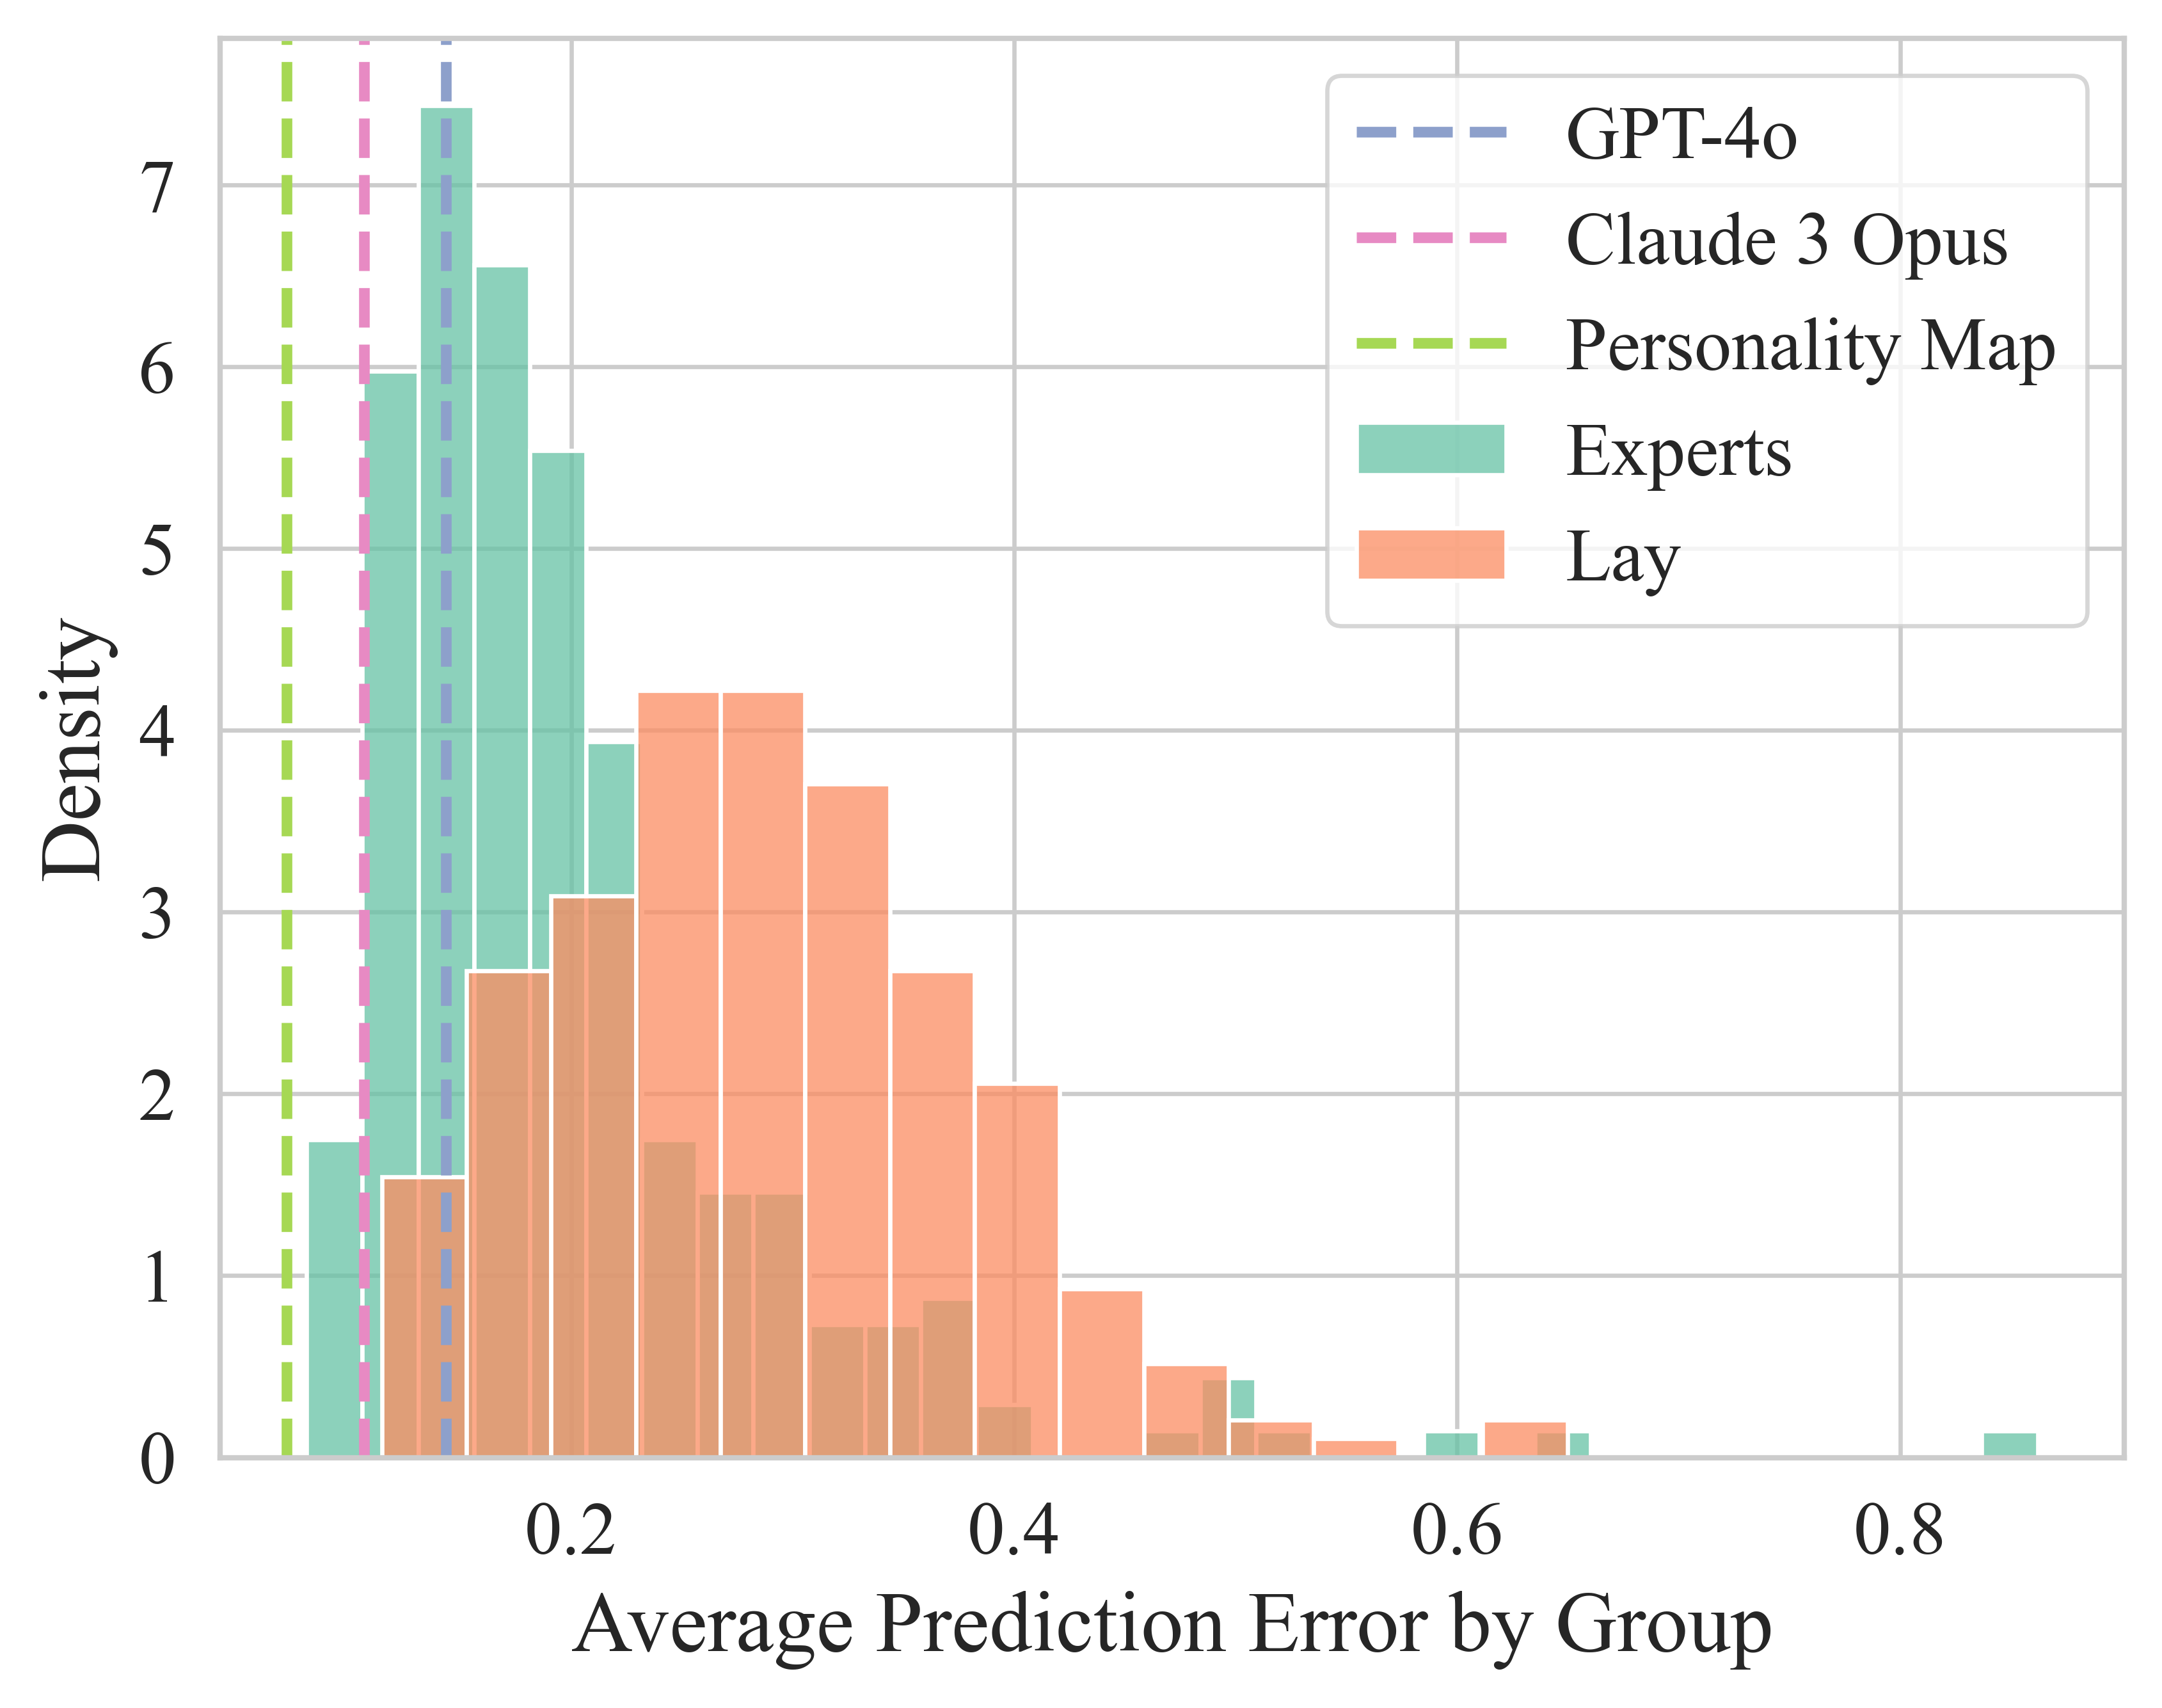

In [17]:
sns.histplot(data = df_all[df_all['Condition']=='Expert'], 
             x = "AvgPredError", 
             # alpha = .5,
             color = color_palette[0],
             stat = "density",
             label = "Experts")
sns.histplot(data = df_all[df_all['Condition']=='Lay'], 
             x = "AvgPredError", 
             # alpha = .5,
             color = color_palette[1],
             stat = "density",
             label = "Lay")



plt.axvline(GPT, label = "GPT-4o", color = color_palette[2], linestyle = "--", linewidth=2)
plt.axvline(claude, label = "Claude 3 Opus", 
            color = color_palette[3], linestyle = "--", linewidth=2)
plt.axvline(PM, label = "Personality Map", color = color_palette[4], linestyle = "--", linewidth=2)

plt.legend()
plt.xlabel("Average Prediction Error by Group")

plt.savefig("Figures/replication_pred_error.png", dpi = 300)

## Number Needed to Beat

In [Trott (2024)](https://direct.mit.edu/opmi/article/doi/10.1162/opmi_a_00144/121179), I calculate the **Number Needed to Beat (NNB)**, a measure of the number of *humans* needed in a sample such that the sample mean rivals the estimate produced by an LLM. Here, I try to the extend this analysis to the personality prediction dataset.

The basic logic is as follows:

- For each *item*, we select a random subset $k$ of human raters (either `Expert` or `Lay`).
- We then *average* the predicted correlations across this subset.
- We then calculate the *prediction error* between this average and the ground truth.
- We do this for various sizes of $k$.

In [18]:
from itertools import combinations
import random

from tqdm import tqdm

In [19]:
item_cols = [col for col in df.columns if "PredictedCor" in col]

#### Experts

In [20]:
### First, let's focus on experts
df_experts = df[df['Condition']=='Expert']
df_experts.shape

(272, 271)

In [21]:
random.seed(42)
sample_size = 100

pred_errors = []

### For each item...
for item in tqdm(item_cols):

    ## Ground truth
    raw_item = item.replace("PredictedCor", "")
    gt_item = ground_truth[raw_item]
    
    ## Get only non-NA observations
    df_subset = df_experts[~df_experts[item].isna()]

    ### List of expert ppts who rated this item
    expert_ppts = random.sample(list(df_subset['ParticipantID'].values), 10)
    
    for k in range(1, 10):

        ### Get combinations of experts who rated that item
        ppt_combos = combinations(expert_ppts, k)

        ### For each combo, calculate prediction error
        for combo in ppt_combos: # random.sample(ppt_combos, len(expert_ppts)):
            # Get subset
            df_expert_tmp = df_subset[df_subset['ParticipantID'].isin(combo)]

            # Get avg prediction
            avg_prediction = df_expert_tmp[item].mean()
            median_prediction = df_expert_tmp[item].median()
            pred_error_avg = abs(avg_prediction - gt_item)
            pred_error_median = abs(median_prediction - gt_item)

            pred_errors.append({
                'k': k,
                'item': raw_item,
                'avg_prediction': avg_prediction,
                'median_prediction': median_prediction,
                'pred_error_avg': pred_error_avg,
                'pred_error_median': pred_error_median  
            })

100%|█████████████████████████████████████████| 249/249 [00:27<00:00,  9.22it/s]


In [22]:
df_errors_experts = pd.DataFrame(pred_errors)
df_errors_experts.shape

(254478, 6)

#### Lay

In [23]:
### Now lay
df_lay = df[df['Condition']=='Lay']
df_lay.shape

(254, 271)

In [24]:
random.seed(42)
sample_size = 100

pred_errors = []

### For each item...
for item in tqdm(item_cols):

    ## Ground truth
    raw_item = item.replace("PredictedCor", "")
    gt_item = ground_truth[raw_item]
    
    ## Get only non-NA observations
    df_subset = df_lay[~df_lay[item].isna()]

    ### List of lay ppts who rated this item
    lay_ppts = random.sample(list(df_subset['ParticipantID'].values), 10)
    
    for k in range(1, 10):

        ### Get combinations of lay ppts who rated that item
        ppt_combos = combinations(lay_ppts, k)

        ### For each combo, calculate prediction error
        for combo in ppt_combos: 
            # Get subset
            df_lay_tmp = df_subset[df_subset['ParticipantID'].isin(combo)]

            # Get avg prediction
            avg_prediction = df_lay_tmp[item].mean()
            median_prediction = df_lay_tmp[item].median()
            pred_error_avg = abs(avg_prediction - gt_item)
            pred_error_median = abs(median_prediction - gt_item)

            pred_errors.append({
                'k': k,
                'item': raw_item,
                'avg_prediction': avg_prediction,
                'median_prediction': median_prediction,
                'pred_error_avg': pred_error_avg,
                'pred_error_median': pred_error_median  
            })

100%|█████████████████████████████████████████| 249/249 [00:27<00:00,  9.19it/s]


In [25]:
df_errors_lay = pd.DataFrame(pred_errors)
df_errors_lay.shape

(254478, 6)

### Comparison

Now, we compare the distribution of **average prediction error** per **sample size** $k$ for `Lay` and `Expert` participants to the correlations achieved with the other models.

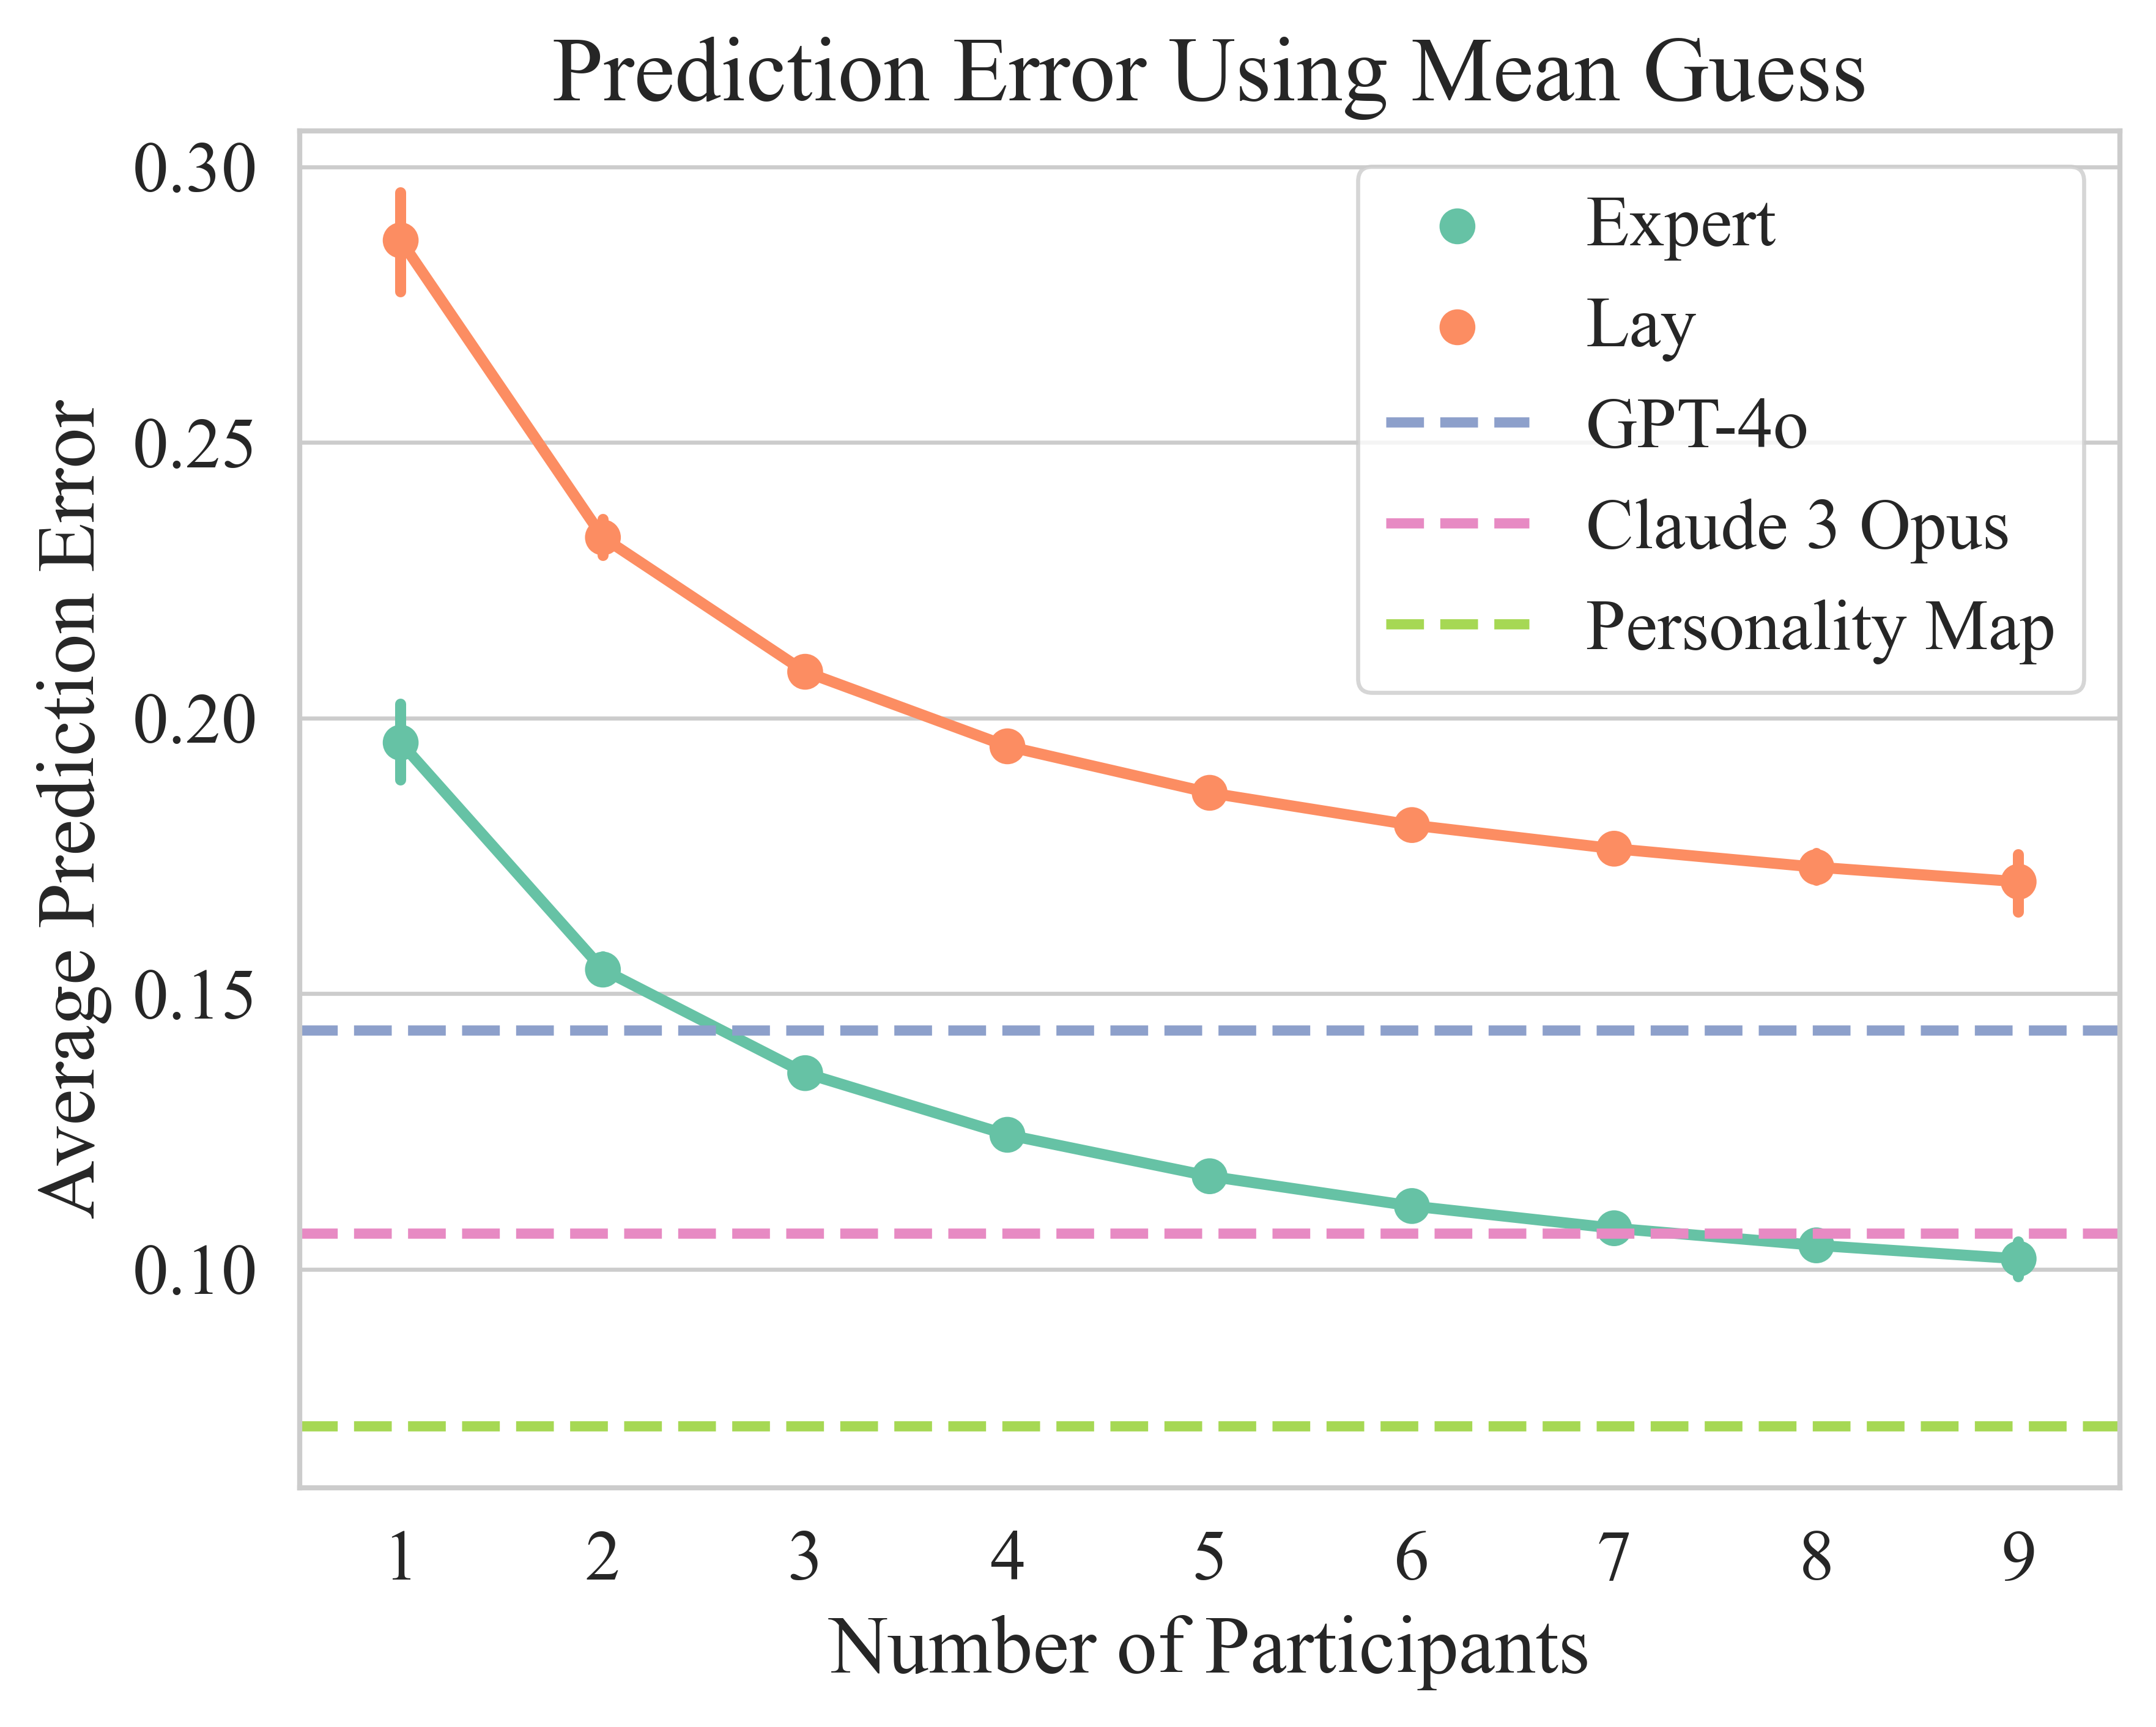

In [26]:
sns.pointplot(data = df_errors_experts, x = "k", y = "pred_error_avg", 
              color = color_palette[0], label = "Expert")
sns.pointplot(data = df_errors_lay, x = "k", y = "pred_error_avg", 
              color = color_palette[1],
              label = "Lay")


plt.axhline(GPT, label = "GPT-4o", color = color_palette[2], linestyle = "--", linewidth=2)
plt.axhline(claude, label = "Claude 3 Opus", 
            color = color_palette[3], linestyle = "--", linewidth=2)
plt.axhline(PM, label = "Personality Map", color = color_palette[4], linestyle = "--", linewidth=2)
plt.legend()

plt.title("Prediction Error Using Mean Guess")
plt.xlabel("Number of Participants")
plt.ylabel("Average Prediction Error")

plt.savefig("Figures/nnb_mean_guess.png", dpi = 300)

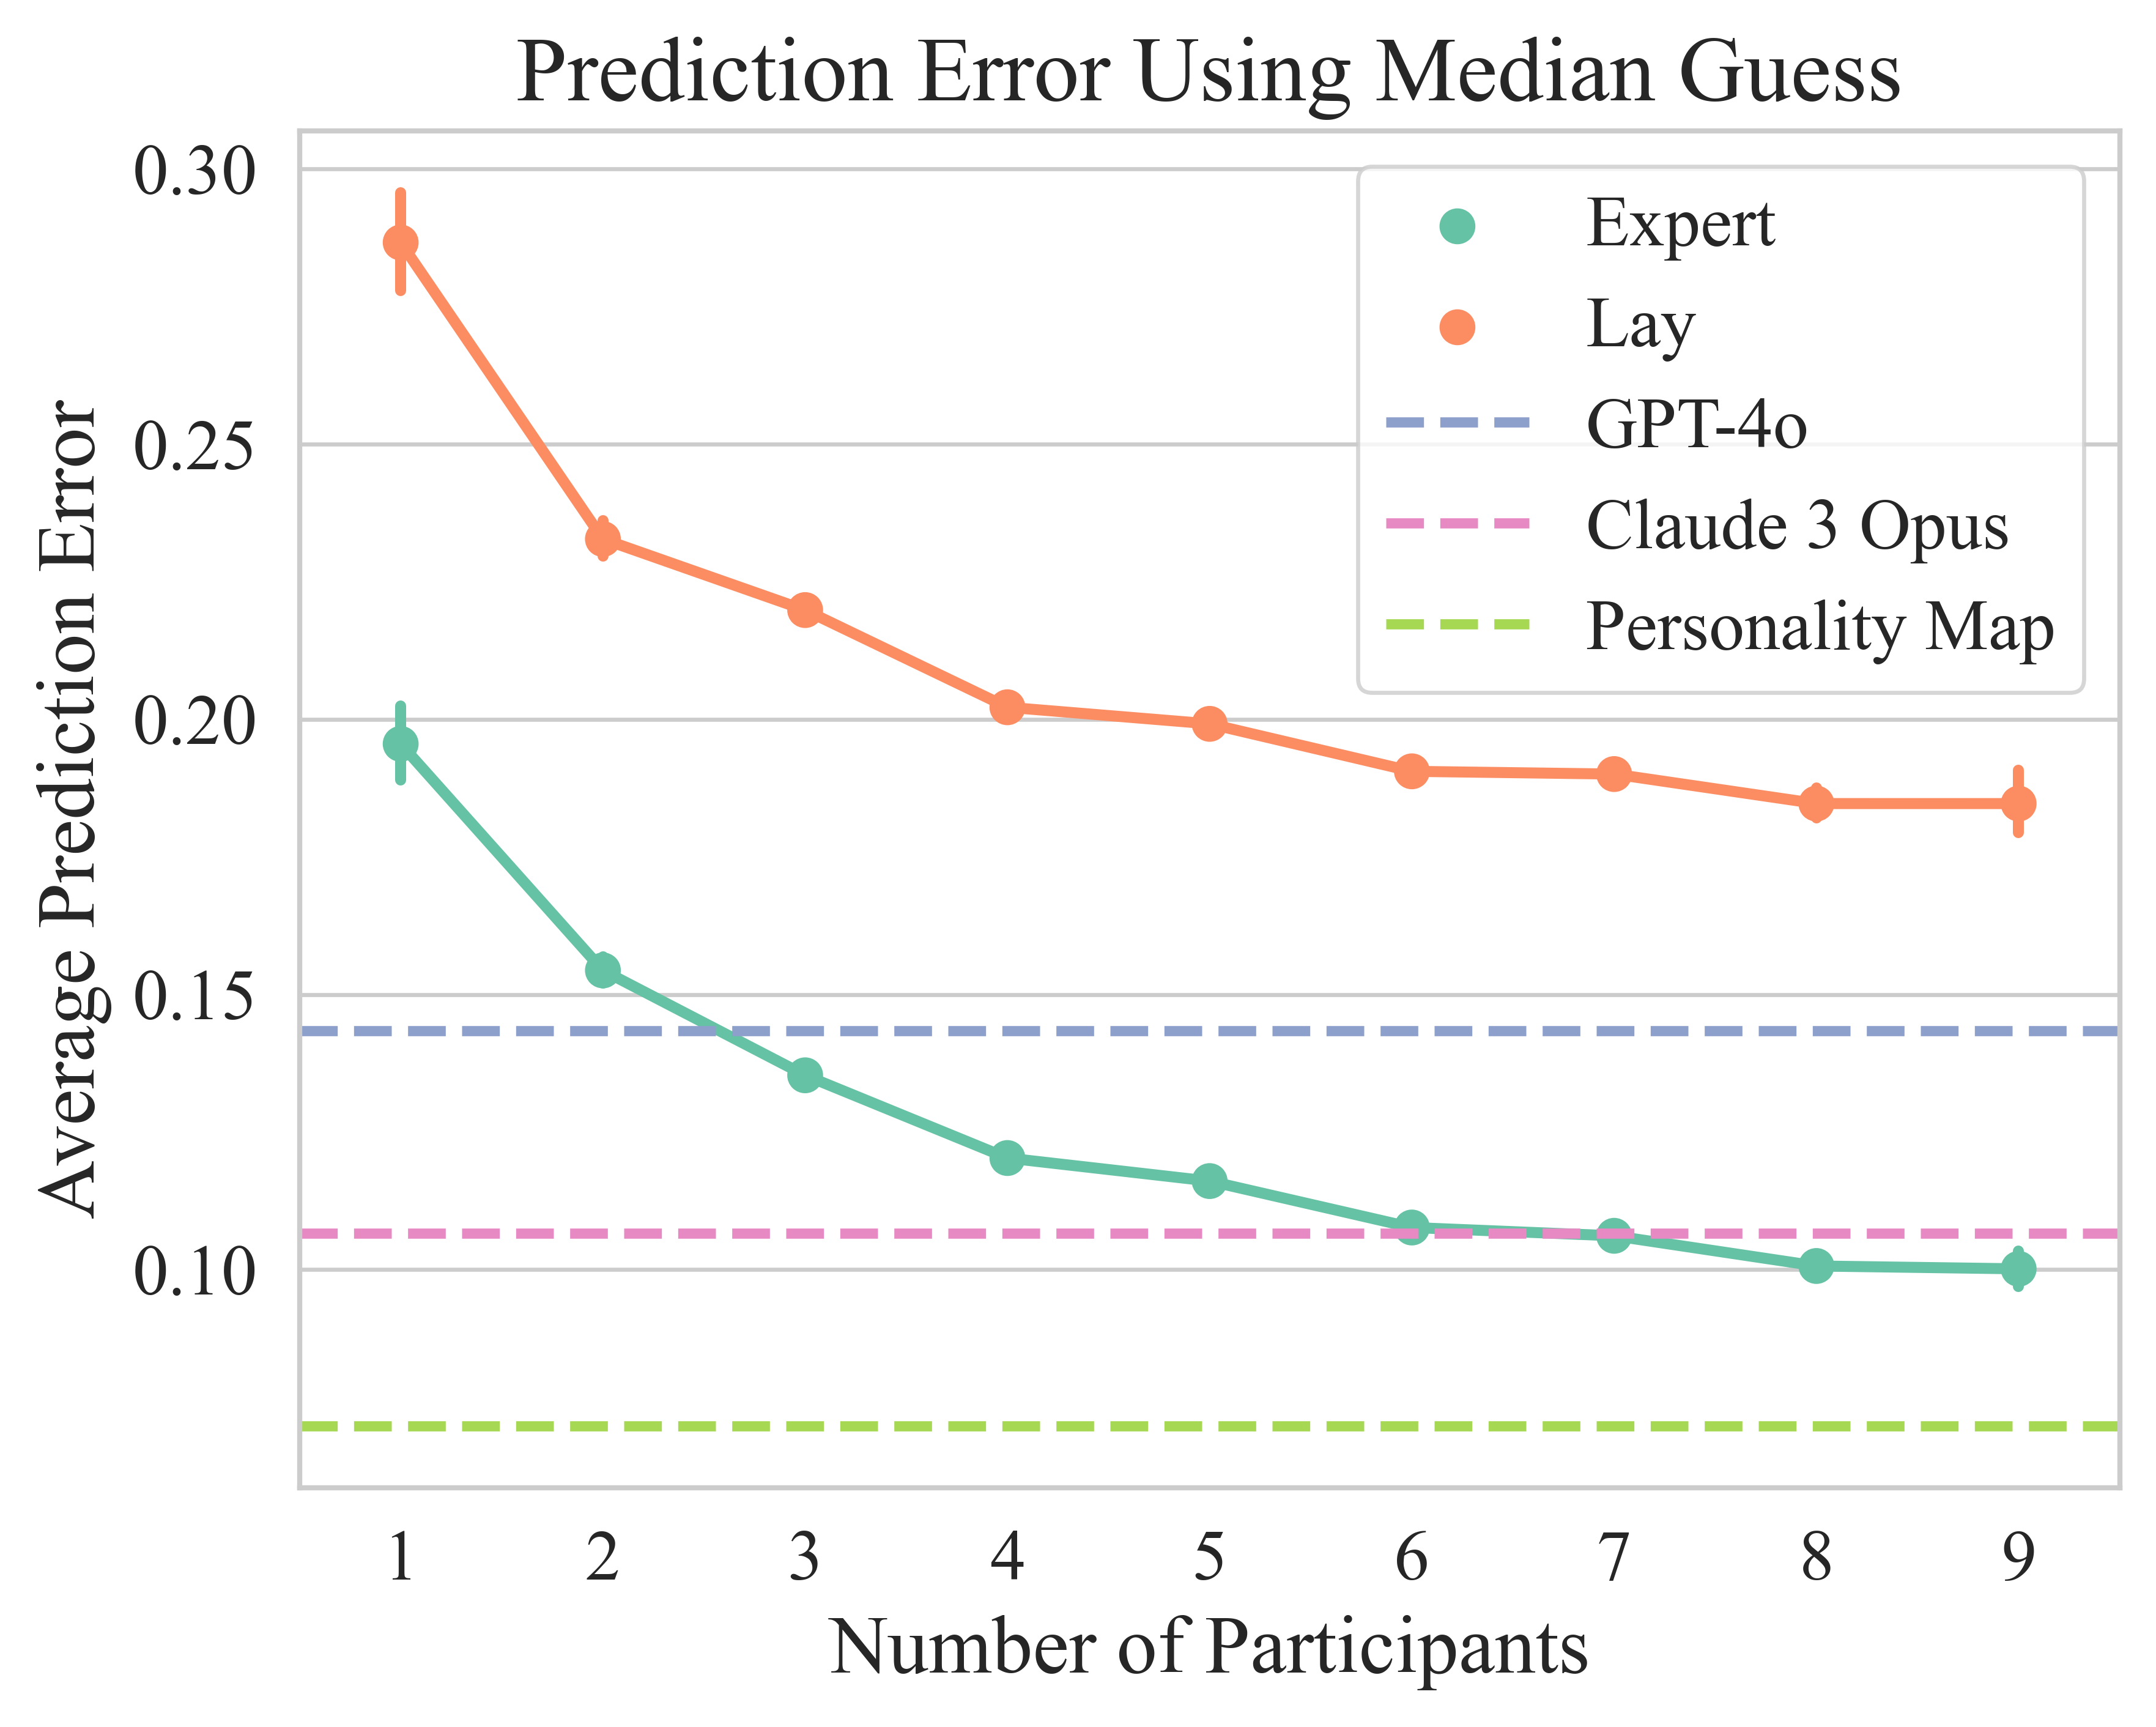

In [27]:
sns.pointplot(data = df_errors_experts, x = "k", y = "pred_error_median", 
              color = color_palette[0], label = "Expert")
sns.pointplot(data = df_errors_lay, x = "k", y = "pred_error_median", 
              color = color_palette[1],
              label = "Lay")


plt.axhline(GPT, label = "GPT-4o", color = color_palette[2], linestyle = "--", linewidth=2)
plt.axhline(claude, label = "Claude 3 Opus", 
            color = color_palette[3], linestyle = "--", linewidth=2)
plt.axhline(PM, label = "Personality Map", color = color_palette[4], linestyle = "--", linewidth=2)
plt.legend()

plt.title("Prediction Error Using Median Guess")
plt.xlabel("Number of Participants")
plt.ylabel("Average Prediction Error")

plt.savefig("Figures/nnb_median_guess.png", dpi = 300)